<a href="https://colab.research.google.com/github/AjaybirRandhawa/StockPrediction/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from google.colab import files
uploaded = files.upload()
sns.set()
tf.compat.v1.random.set_random_seed(1234)


Saving GOOG (1).csv to GOOG (1) (1).csv


In [72]:
import io
df = pd.read_csv(io.BytesIO(uploaded['GOOG (1).csv']))
# Dataset is now stored in a Pandas Dataframe

In [73]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
1,2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
2,2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
3,2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
4,2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000


In [74]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.402855
1,0.394156
2,0.437650
3,0.436522
4,0.450756


In [75]:
test_size = 10
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((253, 7), (243, 1), (10, 1))

In [76]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [77]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [78]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [79]:
results = []
for i in range(simulation_size):
    results.append(forecast())

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:02<00:00,  4.81it/s, acc=96.4, cost=0.00325]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:02<00:00,  4.83it/s, acc=96.9, cost=0.00249]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:03<00:00,  4.71it/s, acc=96.7, cost=0.00273]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:04<00:00,  4.68it/s, acc=96.9, cost=0.0025]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:03<00:00,  4.69it/s, acc=96.8, cost=0.0025]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:01<00:00,  4.86it/s, acc=96.8, cost=0.00262]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:01<00:00,  4.88it/s, acc=96.1, cost=0.0038]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:02<00:00,  4.79it/s, acc=96.8, cost=0.00256]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:04<00:00,  4.68it/s, acc=96.6, cost=0.00293]


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [01:03<00:00,  4.76it/s, acc=95.8, cost=0.00454]


In [80]:
average_list = []
for x in range(test_size):
  average = 0
  for y in range(simulation_size):
    average += results[y][x]
  average = average/simulation_size
  average_list.append(average)
  print(average)
df.tail(test_size)

1760.9137237766056
1761.2850451385596
1760.2007681629534
1764.0895505623278
1763.2139100915094
1768.0845987048044
1770.6041718002682
1784.2437590773836
1800.5563524514957
1819.895571086376


,Date,Open,High,Low,Close,Adj Close,Volume
243,2020-12-17,1768.510010,1771.784058,1738.660034,1747.900024,1747.900024,1624700
244,2020-12-18,1754.180054,1755.109985,1720.219971,1731.010010,1731.010010,4016400
245,2020-12-21,1713.510010,1740.849976,1699.000000,1739.369995,1739.369995,1828400
246,2020-12-22,1734.430054,1737.405029,1712.574951,1723.500000,1723.500000,936700
247,2020-12-23,1728.109985,1747.989990,1725.040039,1732.380005,1732.380005,1033800
248,2020-12-24,1735.000000,1746.000000,1729.109985,1738.849976,1738.849976,346800
249,2020-12-28,1751.635010,1790.728027,1746.334961,1776.089966,1776.089966,1393000
250,2020-12-29,1787.790039,1792.439941,1756.089966,1758.719971,1758.719971,1299400
251,2020-12-30,1762.010010,1765.094971,1725.599976,1739.520020,1739.520020,1306100
252,2020-12-31,1735.420044,1758.930054,1735.420044,1751.880005,1751.880005,1011900


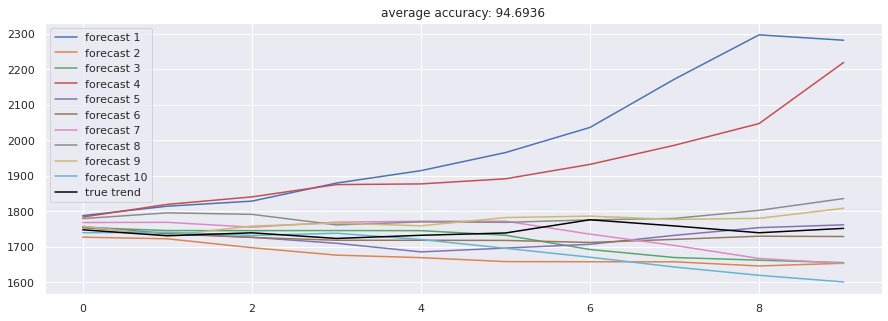

In [81]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

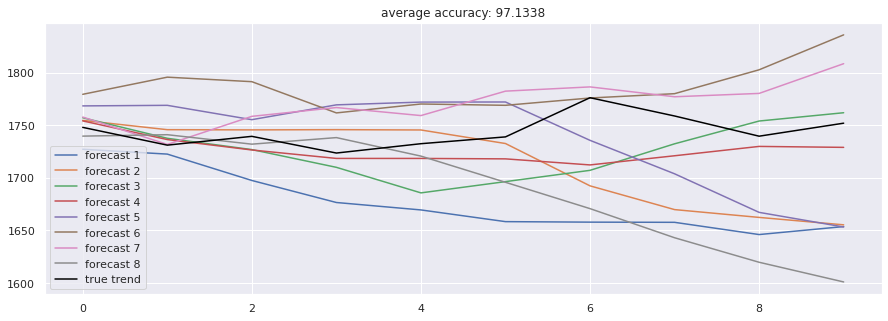

In [87]:
most_accurate = results[1:]
del most_accurate[2]
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, a) for a in most_accurate]
plt.figure(figsize=(15,5))
for no, r in enumerate(most_accurate):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()